In [110]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rc
rc('font',**{'size': 22})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
rc('font',**{'size': 22})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

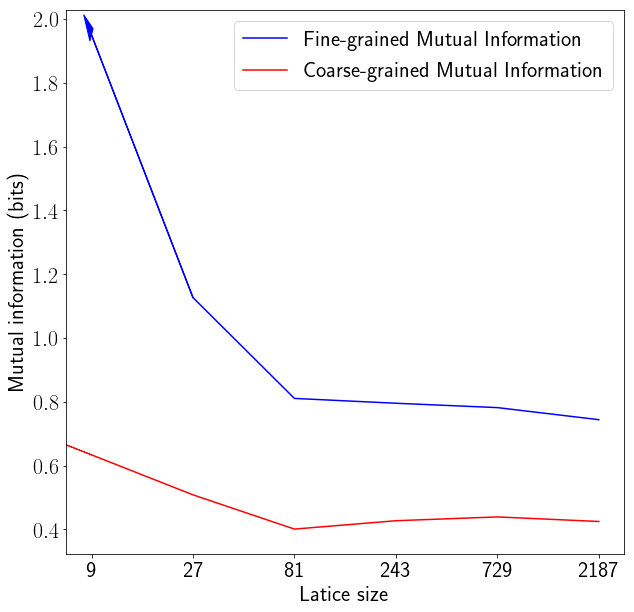

In [121]:
a = [0.7437676312230461, 0.7816341840316443,0.795270527035214, 0.8104184290659728, 1.126535739351302, 1.9499505731379898]
b=[0.6335324802566205, 0.5081651136320254, 0.40077747534866137, 0.4269913639143416, 0.4389315622245423, 0.4246509224561651]
plt.figure(figsize=(10,10))
plt.xlabel("Latice size")
plt.ylabel("Mutual information (bits)")
#         axs[i, j].text(0.5, 0.5, r"{}".format(title[i][j]))
# axs[i, j].errorbar( range(6), ratios[i][j][::-1],color="blue", yerr=stds[i][j][::-1], ecolor="red", capsize=0 if i == j and i == 0 else 10)
#         print("ratios[i][j][::-1]", ratios[i][j][::-1])
# print("stds[i][j][::-1]", stds[i][j][::-1])
plt.plot(range(2,8), a[::-1], label="Fine-grained Mutual Information", color="blue")
plt.plot(range(2,8), b, label="Coarse-grained Mutual Information",color="red")
plt.arrow(3, a[::-1][1], -1, a[::-1][0]-a[::-1][1],head_width=0.05,head_length=0.1,color="blue")
plt.arrow(2, b[::-1][-1], -1, b[::-1][-1]-b[::-1][-2],head_width=0.05,head_length=0.1,color="red")
plt.xticks(range(2,8),np.power(3, np.arange(2, 8)))
plt.legend()
# axs[i, j].set_ylim(-0.9, 1.4)

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
from copy import deepcopy


class IsingModel:
    def __init__(self, size, T = 1, J = 1, h = 0):
        self.size = size # size of lattice
        self.T = T # k_B * temperature (default 1)
        self.J = J # strength of interaction 
        self.h = h # strength of magnetic field
    
    def initialize(self):
        self.state = np.random.choice([-1, 1], (self.size, self.size))
        
    
    def update_mh(self, steps = 10000):
        for _ in range(steps):
            r_ind, c_ind = np.random.choice(self.size, 2)

            energy = self.J * self.state[r_ind][c_ind]*(self.state[(r_ind-1)%self.size][c_ind] + \
                                                self.state[(r_ind+1)%self.size][c_ind] + \
                                                self.state[r_ind][(c_ind-1)%self.size] + \
                                                self.state[r_ind][(c_ind+1)%self.size])
            energy += -self.h * (self.state[r_ind][c_ind]) # generally absent

            prob = min(1, float(np.e**(-2*energy/self.T)))

            if np.random.random() < prob:
                self.state[r_ind][c_ind] *= -1
        
        
    def display(self):
        cmap = colors.ListedColormap(['purple', 'yellow'])
        bounds=[-1,0,1]
        norm = colors.BoundaryNorm(bounds, cmap.N)
        plt.imshow(self.state, interpolation='nearest', origin='lower',
                    cmap=cmap, norm=norm)
    def getNN(self, site_indices, site_ranges, num_NN):
        '''
            site_indices: [i,j], site to get NN of
            site_ranges: [Nx,Ny], boundaries of the grid
            num_NN: number of nearest neighbors, usually 1
            function which gets NN on any d dimensional cubic grid
            with a periodic boundary condition
        '''

        Nearest_Neighbors = list();
        for i in range(len(site_indices)):
            for j in range(-num_NN,num_NN+1): #of nearest neighbors to include
                if(j == 0): continue;
                NN = list(deepcopy(site_indices)); #don't want to overwite;
                NN[i] = (NN[i] + j)%(site_ranges[i]);
                Nearest_Neighbors.append(tuple(NN))
        return Nearest_Neighbors;
    
    def SW_BFS(self, bonded, clusters, start, beta, nearest_neighbors = 1):
        '''
        function currently cannot generalize to dimensions higher than 2...
        main idea is that we populate a lattice with clusters according to SW using a BFS from a root coord
        :param lattice: lattice
        :param bonded: 1 or 0, indicates whether a site has been assigned to a cluster
               or not
        :param clusters: dictionary containing all existing clusters, keys are an integer
                denoting natural index of root of cluster
        :param start: root node of graph (x,y)
        :param beta: temperature
        :param J: strength of lattice coupling
        :param nearest_neighbors: number or NN to probe
        :return:
        '''
        N = self.state.shape;
        visited = np.zeros(N); #indexes whether we have visited nodes during
                                     #this particular BFS search
        if(bonded[tuple(start)] != 0): #cannot construct a cluster from this site
            return bonded, clusters, visited;
        
        p = 1 - np.exp(-2 * beta * self.J); #bond forming probability
        
        queue = list();
        

        queue.append(start);
        index = tuple(start)
        clusters[index] = [index];
        cluster_spin = self.state[index]
        color = np.max(bonded) + 1;

        ## need to make sub2ind work in arbitrary dimensions
        
        #whatever the input coordinates are
        while(len(queue) > 0):
            #print(queue)
            r = tuple(queue.pop(0));
            ##print(x,y)
            if(visited[r] == 0): #if not visited
                visited[r] = 1;
                #to see clusters, always use different numbers
                bonded[r] = color;
                NN = self.getNN(r,N, nearest_neighbors);
                for nn_coords in NN:
                    rn = tuple(nn_coords);
                    if(self.state[rn] == cluster_spin and bonded[rn] == 0\
                       and visited[rn] == 0): #require spins to be aligned
                        random = np.random.rand();
                        if (random < p):  # accept bond proposal
                            queue.append(rn); #add coordinate to search
                            clusters[index].append(rn) #add point to the cluster
                            bonded[rn] = color; #indicate site is no longer available
        
        return bonded, clusters, visited;
    
    def run_cluster_epoch(self, nearest_neighbors = 1):
        """
        Implements 1 step of the Swendsen Wang algorithm
        """
        #simulation parameters
        beta = 1.0 / self.T
        Nx, Ny = self.state.shape
        
        #scan through every element of the lattice

        #propose a random lattice site to generate a cluster
        bonded = np.zeros((Nx,Ny));
        clusters = dict();  # keep track of bonds
        ## iterate through the entire lattice to assign bonds
        ## and clusters
        for i in range(Nx):
            for j in range(Ny):
                ## at this point, we do a BFS search to create the cluster
                bonded, clusters, visited = self.SW_BFS(bonded, clusters, [i,j], beta, nearest_neighbors=1);
        
        
        for cluster_index in clusters.keys():
            [x0, y0] = np.unravel_index(cluster_index, (Nx,Ny));
            r = np.random.rand();
            if(r < 0.5):
                for coords in clusters[cluster_index]:
                    [x,y] = coords;
                    #print(Lattice[x,y], end=', '); #check clusters
                    self.state[x,y] = -1*self.state[x,y];

        return self.state;
    
    def update_SW(self, steps = 30):
        """
        Runs some steps of the Swendsen Wang algorithm
        """
        for _ in range(steps):
            self.run_cluster_epoch()
        



# Generating Correlated Data
also in `./generate_data.py`

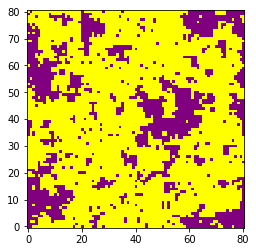

In [23]:
# Visualizing
data = []
for _ in range(1):
    i = IsingModel((81), T = 2.269) # change T to sample at different temperatures
    i.initialize()
    for _ in range(3):
        i.update_SW(3) # use the Swendsen-Wang algorithm
        # to use the Metropolis-Hastings algorithm do
        # i.update_mh(steps=10000)
    data.append(i.state)
data = np.array(data)
i.display()

In [18]:
# Generating 10000 samples and save them
"""for temp in [1, 2.269185, 5]:
    data = []
    for _ in range(10000):
        i = IsingModel((81), 2.269185)
        i.initialize()
        for _ in range(10):
            i.update_SW(1)
        data.append(i.state)
    data = np.array(data)
    np.save("ising81x81_temp_{}.npy".format(temp), data)"""

'for temp in [1, 2.269185, 5]:\n    data = []\n    for _ in range(10000):\n        i = IsingModel((81), 2.269185)\n        i.initialize()\n        for _ in range(10):\n            i.update_SW(1)\n        data.append(i.state)\n    data = np.array(data)\n    np.save("ising81x81_temp_{}.npy".format(temp), data)'

# Generate uncorrelated samples
also in `supervised_convnet/generate_uncorrelated_data.py`

In [29]:
data = np.load("supervised_convnet/t_2.269/ising81x81_temp2.269.npy")[:, :9, :9]
# print("data", data[:10])
# Create uncorrelated samples
uncorrelated_data = []
for _ in range(10000):
    # Get random block from 10000 samples
    sample = np.random.randint(0, 10000, (3, 3))
    # Pick horizontal, vertical position of 3x3 block in 9x9 block
    horizontal, vertical = np.random.randint(0, 3, (2, 3, 3))
    # Concatenate blocks
    uncorrelated = []
    for i in range(3):
        tile = []
        for j in range(3):
            block = 
            tile.append(data[sample[i, j], 3*horizontal[i, j]:(3*horizontal[i, j] + 3), \
                    3*vertical[i, j]:(3*vertical[i, j] + 3)])
        uncorrelated.append(np.hstack(tile))
    uncorrelated_data.append(np.vstack(uncorrelated))

uncorrelated_data = np.array(uncorrelated_data)
print(f"uncorrelated_data \n", uncorrelated_data[0])
# np.save("../ising81x81_temp5_uncorrelated9x9.npy", uncorrelated_data)

uncorrelated_data 
 [[-1 -1 -1  1  1  1  1  1  1]
 [-1 -1 -1  1  1  1  1  1  1]
 [-1 -1 -1  1  1  1  1 -1 -1]
 [-1 -1 -1 -1 -1 -1  1  1  1]
 [ 1  1 -1 -1 -1 -1  1  1 -1]
 [ 1  1  1 -1 -1 -1  1  1 -1]
 [-1  1 -1 -1  1  1 -1 -1 -1]
 [ 1  1  1  1  1  1 -1 -1 -1]
 [ 1  1  1  1  1  1 -1 -1 -1]]


In [35]:
uncorrelated_data = np.array(uncorrelated_data)

## For 2187x2187 -> 9x9

In [39]:
import ray
ray.init()

@ray.remote
def gen_uncorr_matrices():
    uncorrelated_data = []
    for _ in range(int((10000-1948)/4)):
        if len(uncorrelated_data ) % 100 == 0:
            print(len(uncorrelated_data))
        # Get random block from 10000 samples
        sample = np.random.randint(1, 10000, (3, 3))

        # Get random chain from 0 to 3
        chain = np.random.randint(0, 4, (3, 3))

        # Pick horizontal, vertical position of 3x3 block in 9x9 block
        horizontal, vertical = np.random.randint(0, lattice_size, (2, 3, 3))

        # Concatenate blocks
        uncorrelated = []
        for i in range(3):
            tile = []
            for j in range(3):
                sample_num = str(sample[i,j])
                zeros = "0" * (5 - len(sample_num))
                block = np.load(f"ising_dat/data_2187_1572395896/lattice_{zeros}{sample_num}_chain_{chain[i, j]}.npz")["arr_0"]
                if (horizontal[i, j] >= lattice_size - 3 ) or (vertical[i, j] >= lattice_size - 3):
                    block = np.pad(block, 2, mode = "wrap")
                block = block[horizontal[i,j]:((horizontal[i,j] + 3)), vertical[i,j]:((vertical[i,j] + 3))]
                tile.append(block)
            try:
                uncorrelated.append(np.hstack(tile))
            except:
                print("hstack failure")
                print("horizontal", horizontal)
                print("vertical", vertical)
                print("tile", tile)
        try:
            uncorrelated_data.append(np.vstack(uncorrelated))
        except:
            print("vstack failure")
            print("horizontal", horizontal)
            print("vertical", vertical)
            print("tile", tile)
    return uncorrelated_data

uncorr_parallel_ids = []
for _ in range(4):
    uncorr_parallel_ids.append(gen_uncorr_matrices.remote())
    
uncorr_parallel = ray.get(uncorr_parallel_ids)

ray.shutdown()

2019-11-11 16:34:46,211	WARNING worker.py:1268 -- WARNING: Not updating worker name since `setproctitle` is not installed. Install this with `pip install setproctitle` (or ray[debug]) to enable monitoring of worker processes.
2019-11-11 16:34:46,214	INFO resource_spec.py:205 -- Starting Ray with 2.88 GiB memory available for workers and up to 1.44 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


(pid=47885) 0
(pid=47876) 0
(pid=47882) 0
(pid=47875) 0
(pid=47885) 100
(pid=47876) 100
(pid=47875) 100
(pid=47882) 100
(pid=47885) 200
(pid=47876) 200
(pid=47882) 200
(pid=47875) 200
(pid=47885) 300
(pid=47876) 300
(pid=47882) 300
(pid=47875) 300
(pid=47885) 400
(pid=47876) 400
(pid=47875) 400
(pid=47882) 400
(pid=47885) 500
(pid=47876) 500
(pid=47875) 500
(pid=47882) 500
(pid=47885) 600
(pid=47876) 600
(pid=47875) 600
(pid=47882) 600
(pid=47885) 700
(pid=47876) 700
(pid=47882) 700
(pid=47875) 700
(pid=47885) 800
(pid=47876) 800
(pid=47875) 800
(pid=47882) 800
(pid=47885) 900
(pid=47876) 900
(pid=47875) 900
(pid=47882) 900
(pid=47885) 1000
(pid=47876) 1000
(pid=47875) 1000
(pid=47882) 1000
(pid=47885) 1100
(pid=47876) 1100
(pid=47875) 1100
(pid=47882) 1100
(pid=47885) 1200
(pid=47876) 1200
(pid=47882) 1200
(pid=47875) 1200
(pid=47885) 1300
(pid=47876) 1300
(pid=47882) 1300
(pid=47875) 1300
(pid=47885) 1400
(pid=47876) 1400
(pid=47882) 1400
(pid=47875) 1400
(pid=47885) 1500
(pid=47876)

In [43]:
arr_list = []
for arr in uncorr_parallel:
    arr_list.extend(arr)

In [47]:
partial_arr = np.load("partial_uncorrelated_data.npy")

In [46]:
arr_list = np.array(arr_list)

In [53]:
np.vstack([partial_arr, arr_list])

array([[[0, 0, 1, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0]],

       [[0, 1, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 1, ..., 0, 1, 1],
        [0, 0, 1, ..., 0, 1, 1],
        [0, 1, 1, ..., 0, 1, 1]],

       [[0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 1, 0]],

       ...,

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 0],
        [0, 1, 1, ..., 1, 1, 0],
        ...,
        [0, 0, 0, ..., 0, 1, 1],
        [0, 0, 0, ..., 0, 1, 1],
        [1, 0, 0, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 0, 0, 1],
        [1, 0, 0, ..., 0, 0, 1],
        [1, 0, 0, ..., 0, 0, 1],
        ...,
        [0, 0, 0, ..., 

## For 729x729 -> 9x9

In [ ]:
import ray
ray.init()

@ray.remote
def gen_uncorr_matrices():
    data = np.load("ising_temp2.269_correlated243x243from729x729.npy")
    lattice_size = data.shape[-1]
    uncorrelated_data = []
    for _ in range(int((4)/4)):
        if len(uncorrelated_data ) % 100 == 0:
            print(len(uncorrelated_data))
        # Get random block from 10000 samples
        sample = np.random.randint(0, 9999, (3, 3))

        # Get random chain from 0 to 3
        chain = np.random.randint(0, 4, (3, 3))

        # Pick horizontal, vertical position of 3x3 block in 9x9 block
        horizontal, vertical = np.random.randint(0, lattice_size, (2, 3, 3))

        # Concatenate blocks
        uncorrelated = []
        for i in range(3):
            tile = []
            for j in range(3):
                sample_num = str(sample[i,j])
                zeros = "0" * (5 - len(sample_num))
                block = data[sample]
                if (horizontal[i, j] >= lattice_size - 3 ) or (vertical[i, j] >= lattice_size - 3):
                    block = np.pad(block, 2, mode = "wrap")
                block = block[horizontal[i,j]:((horizontal[i,j] + 3)), vertical[i,j]:((vertical[i,j] + 3))]
                tile.append(block)
            try:
                uncorrelated.append(np.hstack(tile))
            except:
                print("hstack failure")
                print("horizontal", horizontal)
                print("vertical", vertical)
                print("tile", tile)
        try:
            uncorrelated_data.append(np.vstack(uncorrelated))
        except:
            print("vstack failure")
            print("horizontal", horizontal)
            print("vertical", vertical)
            print("tile", tile)
    return uncorrelated_data

uncorr_parallel_ids = []
for _ in range(4):
    uncorr_parallel_ids.append(gen_uncorr_matrices.remote())
    
uncorr_parallel = ray.get(uncorr_parallel_ids)

ray.shutdown()

# Generate Correlated Data

In [8]:
import numpy as np
lattice_size = 2187
# import ray
# ray.init()
# @ray.remote
# def gen_uncorr_matrices():

for batch in range(2, 11):
    tile = []
    for _ in range(int((1000))):
        if _ % 100 == 0:
            print(_)
        # Get random block from 10000 samples
        sample, = np.random.randint(1, 10000, 1)

        # Get random chain from 0 to 3
        chain, = np.random.randint(0, 4, 1)

        # Pick horizontal, vertical position of 3x3 block in 9x9 block
        horizontal, vertical = np.random.randint(0, lattice_size, 2)

    #     print(sample, chain, horizontal, vertical)

        sample_num = str(sample)
        zeros = "0" * (5 - len(sample_num))

        block = np.load(f"ising_dat/data_2187_1572395896/lattice_{zeros}{sample_num}_chain_{chain}.npz")["arr_0"]
        if (horizontal >= lattice_size - 9 ) or (vertical >= lattice_size - 9):
            block1 = np.pad(block, 8, mode = "wrap")
            tile.append(block1[horizontal:((horizontal + 9)), vertical:((vertical + 9))])
            del block1

        else:
            tile.append(block[horizontal:((horizontal + 9)), vertical:((vertical + 9))])
    #         block = block[horizontal:((horizontal + 9)), vertical:((vertical + 9))]

    #         print(tile)
        del block
    tile = np.array(tile)
    np.save(f"correlated_batch{batch}", tile)
#     return tile

# corr_parallel_ids = []
# for _ in range(1):
#     corr_parallel_ids.append(gen_uncorr_matrices.remote())
    
# corr_parallel = gen_uncorr_matrices()
# ray.shutdown()

0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900


In [14]:
b = []
for batch in range(1, 11):
    b.append(np.load(f"correlated_batch{batch}.npy"))
    

b = np.vstack(b)

In [18]:
b[901]

array([[1, 1, 0, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 0, 1, 1, 1, 1],
       [1, 1, 1, 0, 0, 1, 1, 1, 1],
       [1, 1, 1, 0, 0, 0, 1, 1, 1],
       [1, 1, 1, 0, 0, 0, 0, 0, 1],
       [1, 1, 1, 0, 0, 0, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1]])

# Neural Network Architecture
also in `supervised_convnet/supervised_convnet.py`

In [38]:
import torch
import torch.nn as nn
import torch.autograd as autograd
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
import math
import numpy as np
import sys

# Load parameters
class SupervisedConvNet(nn.Module):
    def __init__(self, filter_size, square_size, hidden_size, num_hidden_layers, center,
                first_activation = "tanh", activation_func = "sigmoid",
                out_channels = 1):
        """
        Arguments:
        filter_size ~ size of the convolution kernel (3 x 3)
        square size ~ how many strides of convolution in the input
        """
        super(SupervisedConvNet, self).__init__()
        self.filter_size = filter_size
        self.square_size = square_size
        self.hidden_size = hidden_size
        self.out_channels = out_channels
        if first_activation == "tanh":
            self.first_activation = torch.tanh
        elif first_activation == "relu":
            self.first_activation = torch.nn.LeakyReLU(0.1)
        if activation_func == "sigmoid":
            self.activation_func = torch.sigmoid
        elif activation_func == "relu":
            self.activation_func = torch.nn.LeakyReLU(0.1)

        self.conv1 = nn.Conv2d(1, out_channels, filter_size, padding=0, stride = filter_size)
        # parameters
        param = {}
        if center == "keep":
            param['conv2d.weight'] = torch.tensor([[[[1.0, 1.0, 1.0],
                      [1.0, 1.0, 1.0],
                      [1.0, 1.0, 1.0]]]])/9
            # param['conv2d.bias'] = torch.tensor([0.0])
        elif center == "omit":
            param['conv2d.weight'] = torch.tensor([[[[1.0, 1.0, 1.0],
                      [1.0, 0.0, 1.0],
                      [1.0, 1.0, 1.0]]]])/8
            # param['conv2d.bias'] = torch.tensor([0.0])
        elif center == "pre_trained":
            param['conv2d.weight'] = torch.tensor([[[[ 0.5417, -0.0390,  0.5055],
          [-0.0826, -0.0543, -0.1356],
          [ 0.4852, -0.0602,  0.5061]]]])
            param['conv2d.bias'] = torch.tensor([-0.0523])

            self.conv1.bias = torch.nn.Parameter(param['conv2d.bias'], requires_grad=False)
        self.conv1.weight = torch.nn.Parameter(param['conv2d.weight'], requires_grad=False)


        self.first_linear = nn.Linear(self.out_channels * square_size ** 2, hidden_size)
        hidden_layer = [nn.Linear(hidden_size, hidden_size) for _ in range(num_hidden_layers)]
        self.linear_hidden = nn.ModuleList(hidden_layer)
        self.linear_output = nn.Linear(hidden_size, 1)



    def forward(self, x):
        x = self.first_activation(self.conv1(x))#.view(-1, 1, self.out_channels * self.square_size**2)
#         x = self.activation_func(self.first_linear(x))
#         for linear in self.linear_hidden:
#             x = self.activation_func(linear(x))
#         x = torch.sigmoid(self.linear_output(x))
#         x = x.squeeze(1)

        return x



In [1]:
import pickle
run_mode = "unfrozen_convolution_relu"
lattice = "9x9"
with open(f"supervised_convnet/t_2.269/x3x3/hyperparameters_{run_mode}_for_{lattice}.pl", "rb") as handle:
    hyper = pickle.load(handle)
accuracy_list = hyper["best_val_acc_hist"]
conv_params = hyper["conv_params"]

In [2]:
accuracy_list

[0.931,
 0.9435,
 0.943,
 0.947,
 0.967,
 0.96,
 0.956,
 0.9745,
 0.938,
 0.903,
 0.926,
 0.914,
 0.4965,
 0.441,
 0.524,
 0.515,
 0.951,
 0.9445,
 0.951,
 0.94,
 0.499,
 0.49,
 0.6615,
 0.943,
 0.422,
 0.798,
 0.5685,
 0.72,
 0.948,
 0.947,
 0.942,
 0.95,
 0.949,
 0.9615,
 0.941,
 0.9435,
 0.9625,
 0.9505,
 0.9575,
 0.9415,
 0.9635,
 0.968,
 0.9625,
 0.958,
 0.961,
 0.958,
 0.9565,
 0.9585,
 0.9575,
 0.948,
 0.957,
 0.956,
 0.958,
 0.9425,
 0.956,
 0.958,
 0.9615,
 0.9495,
 0.958,
 0.952,
 0.954,
 0.941,
 0.9465,
 0.949,
 0.9515,
 0.961,
 0.953,
 0.959,
 0.969,
 0.9465,
 0.9355,
 0.9635,
 0.9345,
 0.957,
 0.9445,
 0.938,
 0.9765,
 0.9355,
 0.9545,
 0.951,
 0.961,
 0.961,
 0.947,
 0.938,
 0.9465,
 0.936,
 0.9475,
 0.9705,
 0.9665,
 0.9315,
 0.9605,
 0.9625,
 0.94,
 0.937,
 0.953,
 0.957,
 0.9575,
 0.9415,
 0.5875,
 0.954,
 0.962,
 0.958,
 0.956,
 0.9605,
 0.961,
 0.9525,
 0.9705,
 0.957,
 0.965,
 0.9575,
 0.9385,
 0.9485,
 0.968,
 0.9665,
 0.952,
 0.9555,
 0.9515,
 0.9605,
 0.9475,
 0.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
accuracy_list = np.array(accuracy_list)
# accuracy_list=accuracy_list[accuracy_list > 0.87]
argmax = np.argmax(accuracy_list)

In [4]:
np.argsort(accuracy_list)[-5:]

array([752, 480, 626, 707, 517])

In [6]:
np.sort(accuracy_list)[-5:]

array([0.9815, 0.982 , 0.982 , 0.983 , 0.983 ])

In [9]:
conv_params = hyper["conv_params"]
conv_params["weight"][517]

tensor([[[[ 0.5417, -0.0390,  0.5055],
          [-0.0826, -0.0543, -0.1356],
          [ 0.4852, -0.0602,  0.5061]]]])

In [10]:
conv_params["bias"][517]

tensor([-0.0523])

In [5]:
np.argsort(accuracy_list)

array([ 79, 200,   4,  55,  30, 177,   1, 186,  23,  22, 194,  78,   0,
        33,  87, 191,  14, 199,  20, 203,   9, 193, 204,   2,   6, 189,
         5,  13,  64, 190,  57, 103,  70,  69,  93,  47,  48,  41,   7,
        16, 157,  25,  36,  27,  26,  18,  56,  34,   3, 133,  19, 121,
       192, 175,  42,  82,  62,  65,  21, 114,  81,  10, 123, 122,  24,
        11,  49,  35,  72,  59, 166, 130,  80, 112, 142,  29, 104, 147,
        44, 139, 138, 110, 113,  40,  77,  39,  12,  75,  37,  83,  88,
        31,  43,  17, 170, 197, 187, 118,  32, 155, 174, 120, 195,  28,
       185, 125,  68, 182,  52, 153,  38, 201, 159, 151, 198, 202, 101,
       100, 124, 154, 131,  46,  76,  86,  74, 165, 156, 102, 108,  54,
        15, 173,  66, 160, 109,  50,  94, 137, 171,  92,  95,  58,  90,
       105, 180,  98, 115, 149, 150,  85,   8,  71,  63,  53,  84, 196,
       146,  45,  61, 163, 162, 161, 135, 116, 178, 172, 145, 127, 179,
       158,  89,  73, 188, 168, 111, 129,  51, 126,  97, 183, 10

In [4]:
np.sort(accuracy_list)

array([0.8715, 0.8725, 0.8725, 0.876 , 0.8765, 0.877 , 0.8785, 0.8785,
       0.879 , 0.879 , 0.879 , 0.8795, 0.8795, 0.881 , 0.8815, 0.882 ,
       0.882 , 0.8825, 0.883 , 0.883 , 0.8845, 0.885 , 0.885 , 0.885 ,
       0.886 , 0.8865, 0.8865, 0.89  , 0.89  , 0.8955, 0.8955, 0.897 ,
       0.8975, 0.8975, 0.8975, 0.8975, 0.8985, 0.8985, 0.899 , 0.9   ,
       0.9   , 0.9005, 0.9005, 0.9015, 0.9015, 0.902 , 0.902 , 0.9025,
       0.903 , 0.9035, 0.904 , 0.9045, 0.9045, 0.9055, 0.9055, 0.9055,
       0.9055, 0.906 , 0.906 , 0.9065, 0.9065, 0.907 , 0.9075, 0.908 ,
       0.908 , 0.908 , 0.908 , 0.9085, 0.909 , 0.9095, 0.91  , 0.91  ,
       0.912 , 0.913 , 0.913 , 0.9135, 0.9145, 0.915 , 0.9155, 0.9155,
       0.9155, 0.916 , 0.916 , 0.916 , 0.916 , 0.9165, 0.9165, 0.919 ,
       0.919 , 0.919 , 0.919 , 0.9195, 0.9195, 0.9195, 0.9195, 0.92  ,
       0.92  , 0.92  , 0.9205, 0.9205, 0.9205, 0.9205, 0.9205, 0.921 ,
       0.9215, 0.922 , 0.9225, 0.9225, 0.9225, 0.9225, 0.9225, 0.923 ,
      

In [28]:
!ls supervised_convnet/t_2.269/x3x3

analysis_copy.ipynb		  hyperopt.ipynb
analysis.ipynb			  hyperopt.py
colab_hyperopt_duplicate_2.ipynb  hyperparameters_unfrozen_convolution_relu.pl
colab_hyperopt_duplicate_3.ipynb  __init__.py
colab_hyperopt_duplicate.ipynb	  ising_temp2.269_correlated9x9.npy
Copy of distribution (1).ipynb	  ising_temp2.269_uncorrelated9x9.npy
Copy of distribution.ipynb	  __pycache__
distributed_hyperopt.py		  supervised_convnet.py
distribution.ipynb		  test.py
distribution.py			  train.py
frozen.py


In [39]:
model = SupervisedConvNet(filter_size = 3, square_size = 3, \
                    hidden_size = 10, out_channels = 1,
                    center = "pre_trained", first_activation = "tanh",
                    activation_func = "relu", num_hidden_layers = 1)
data = []
data = np.load("ising_temp2.269_correlated27x27from81x81.npy")#[-5700:]
data.shape

(9999, 27, 27)

In [40]:
# samples = np.array(np.linspace(200, 9999, 2500), dtype = int)
# coarses = []
leng = 0
for batch in range(1):
#     im_batch = data[100*batch:(100 * batch + 100)]
    im_batch = torch.tensor(data).unsqueeze(1).type('torch.FloatTensor')
    coarse = model(im_batch).squeeze(1).numpy()
    np.save(f"ising_temp2.269_correlated9x9from27x27.npy", coarse)
    
#     print(batch +43)
    

In [33]:
import numpy as np
images = []
for batch in range(100):
    image = np.load(f"ising_temp2.269_correlated243x243from729x729_batch{batch}.npy")
    images.append(image)
images = np.vstack(images)
images.shape

(9999, 243, 243)

In [34]:
np.save("ising_temp2.269_correlated243x243from729x729", images)

# Train Neural Network to distinguish between correlated/uncorrelated samples
also in `train.py` files in each temperature subdirectory e.g. `supervised_convnet/t_2.269/train.py`

In [52]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import sys; 
from supervised_convnet import supervised_convnet
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import sys
from sklearn.model_selection import train_test_split


In [54]:
uncorrelated_data = np.load("supervised_convnet/t_2.269/ising81x81_temp2.269_uncorrelated9x9.npy")
correlated_data = np.load("supervised_convnet/t_2.269/ising81x81_temp2.269.npy")[:10000,:9,:9]
print("Uncorrelated", uncorrelated_data[0])
print("Correlated", correlated_data[0])

data = np.vstack((uncorrelated_data, correlated_data))
label = np.hstack((-np.ones(10000), np.ones(10000)))
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.33, random_state=42)
# raise ValueError

# Create training and test dataloaders
num_workers = 0
# how many samples per batch to load
batch_size = 1000
# number of epochs to train the model
n_epochs = 500
# learning rate
lr = 0.001
# adjust learning rate?
adjust_learning_rate = False

# specify loss function
criterion = nn.MSELoss()

# build model
model = supervised_convnet.SupervisedConvNet(filter_size = 3, square_size = 3)

# specify optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


# prepare data loaders
train_isingdataset = supervised_convnet.IsingDataset(X_train[:3000], y_train[:3000])
train_loader = torch.utils.data.DataLoader(train_isingdataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

validate_isingdataset = supervised_convnet.IsingDataset(X_train[-1000:], y_train[-1000:])
validate_loader = torch.utils.data.DataLoader(validate_isingdataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)



Uncorrelated [[-1 -1 -1 -1  1  1  1  1  1]
 [-1 -1 -1 -1 -1  1 -1 -1  1]
 [-1 -1 -1 -1 -1  1 -1 -1 -1]
 [-1 -1 -1  1  1  1  1  1  1]
 [-1 -1 -1  1  1  1  1  1  1]
 [-1 -1 -1  1  1  1  1  1  1]
 [ 1  1  1  1  1  1  1  1 -1]
 [ 1  1  1  1  1  1 -1 -1 -1]
 [-1  1  1  1  1  1 -1 -1 -1]]
Correlated [[ 1  1 -1  1 -1 -1 -1 -1  1]
 [ 1  1 -1 -1 -1 -1 -1 -1 -1]
 [ 1  1 -1 -1 -1  1  1  1  1]
 [-1 -1 -1 -1 -1 -1  1  1  1]
 [ 1 -1 -1 -1 -1  1  1  1  1]
 [-1 -1 -1 -1 -1  1  1  1  1]
 [-1 -1 -1 -1 -1  1  1 -1 -1]
 [-1 -1 -1 -1 -1 -1  1  1  1]
 [-1 -1  1 -1 -1 -1 -1 -1  1]]


In [56]:
for epoch in range(1, n_epochs+1):
    # monitor training loss
    accuracy = 0.0
    train_loss = 0.0
    # adjust learning rate
    if adjust_learning_rate == True:
        supervised_convnet.adjust_learning_rate(optimizer, epoch, lr)

    ###################
    # train the model #
    ###################
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.unsqueeze(1).type('torch.FloatTensor')
        target = target.type('torch.FloatTensor')
        optimizer.zero_grad()
        output = model(data)[-1].view(-1)
        loss = criterion(output, target) 
        # add regularization
        for param in model.parameters():
            loss += ((param)**2).sum()/300
        loss.backward()
        optimizer.step()

        # update running training loss
        accuracy += (torch.sign(output) == target).sum().item() / batch_size
        train_loss += loss.item() * batch_size
    
    
    # print avg training statistics 
    # train_loss = train_loss/len(train_loader)
    if epoch % 10 == 0:
        validate_accuracy = 0
        for batch_idx, (data, target) in enumerate(validate_loader):
            data = data.unsqueeze(1).type('torch.FloatTensor')
            target = target.type('torch.FloatTensor')
            output = model(data)[-1].view(-1)
            validate_accuracy += (torch.sign(output) == target).sum().item() / batch_size

        print('Epoch: {} \t Accuracy: {} \t Validate_Accuracy: {}'.format(
            epoch, 
            accuracy/len(train_loader),
            validate_accuracy/len(validate_loader),
            ))
#         print("data", data[:10])
        # print("output", (output)[:10])
        # print("target", (target)[:10])
        # for name, param in model.named_parameters():
        #     if param.requires_grad:
        #         print (name, param.data)

patience = 0
for batch_idx, (data, target) in enumerate(train_loader):
    data = data.unsqueeze(1).type('torch.FloatTensor')#[0].unsqueeze(1)
    # print("data", data)
    target = target.type('torch.FloatTensor')
    optimizer.zero_grad()
    output = [i.view(-1) for i in model(data)]
    print("data", data[:10])
    print("output", (output[:10]))
    print("target", target[:10])
    v = torch.tensor([[[[-1., -1., -1., -1., -1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1., -1., -1., -1., -1.]]]])
    print("correlated model(v)", model(v))
    v = torch.tensor([[[[ 1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1.],
        [ 1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1.],
        [ 1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1.],
        [ 1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1.],
        [ 1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1.],
        [ 1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1.],
        [-1., -1., -1.,  1.,  1.,  1., -1., -1., -1.],
        [-1., -1., -1.,  1.,  1.,  1., -1., -1., -1.],
        [-1., -1., -1.,  1.,  1.,  1., -1., -1., -1.]]]])
    print("uncorrelated model(v)", model(v))
    # loss = criterion(output, target[0])
    # print("loss.data", loss.data)
    # loss.backward()
    patience += 1
    if patience > 100:
        break
    

v = torch.tensor([[[[-1., -1., -1., -1., -1., -1., -1., -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1., -1., -1.],
          [-1., -1., -1., -1.,  1., -1., -1., -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1., -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1., -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1., -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1., -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1., -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1., -1., -1.]]]])
print("negative", model(v))
print("positive", model(-v))


Epoch: 10 	 Accuracy: 0.47400000000000003 	 Validate_Accuracy: 0.473
Epoch: 20 	 Accuracy: 0.49866666666666665 	 Validate_Accuracy: 0.491
Epoch: 30 	 Accuracy: 0.5133333333333333 	 Validate_Accuracy: 0.507
Epoch: 40 	 Accuracy: 0.512 	 Validate_Accuracy: 0.519
Epoch: 50 	 Accuracy: 0.5076666666666666 	 Validate_Accuracy: 0.518
Epoch: 60 	 Accuracy: 0.5060000000000001 	 Validate_Accuracy: 0.525
Epoch: 70 	 Accuracy: 0.5100000000000001 	 Validate_Accuracy: 0.529
Epoch: 80 	 Accuracy: 0.514 	 Validate_Accuracy: 0.53
Epoch: 90 	 Accuracy: 0.5133333333333333 	 Validate_Accuracy: 0.535
Epoch: 100 	 Accuracy: 0.515 	 Validate_Accuracy: 0.534
Epoch: 110 	 Accuracy: 0.5156666666666667 	 Validate_Accuracy: 0.529
Epoch: 120 	 Accuracy: 0.5143333333333334 	 Validate_Accuracy: 0.527
Epoch: 130 	 Accuracy: 0.5126666666666666 	 Validate_Accuracy: 0.522
Epoch: 140 	 Accuracy: 0.512 	 Validate_Accuracy: 0.518
Epoch: 150 	 Accuracy: 0.5113333333333333 	 Validate_Accuracy: 0.511
Epoch: 160 	 Accuracy: 0.

Visualize parameters

In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print (name, param.data)

# torch.save(model.state_dict(), "9x9->3x3.pt")
    # optimizer.step()


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import glob

# Correlation check

In [3]:
size = 6561


In [133]:
state.shape

(1, 4, 2187, 2187)

In [81]:
import glob
import numpy as np
from collections import defaultdict

class running_mean:
    def __init__(self):
        self.num_samples = 0.0
        self.current_sum = 0.0
    
    def update(self, values):
        self.num_samples += len(values)
        self.current_sum += np.sum(values)
        
    def get_cur_mean(self):
        return (self.current_sum / self.num_samples) 


In [95]:
# state = np.load("ising2187x2187_temp_1.969185.npy") # np.random.choice([-1, 1], (size, size))
def correlation_check():
    side = 2187
    means = []
    for _ in range(299):
        means.append(running_mean())
    for state_file in glob.glob("data_2187_1572395896/*"):
        
        state = np.load(state_file)["arr_0"] * 2 - 1
        
        for r in range(1, 300):
            num_samples = np.random.randint(1000)
            x, y = np.random.randint(side, size = (2, num_samples))
            i = np.random.randint(r, size = num_samples)
            s_j = state[(x + r)%side, y]
            means[r-1].update(s_j * state[x, y])
            
    return means
means = correlation_check()
avgs = []
for r in range(299):
    avgs.append(means[r].current_sum / means[r].num_samples)

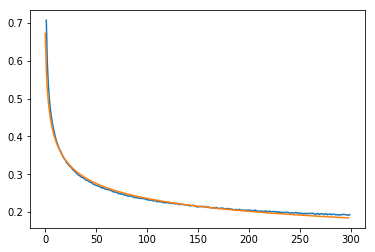

In [98]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

plt.plot(range(1,300), avgs)
plt.plot(target_func(np.arange(1, 300), 0.22687946, 0.67291978))
# plt.show()
# def func_powerlaw(x,alpha,c):
#     return c/x**alpha
# def func_exp(x, A, B):
#     return A * np.exp(B * np.asarray(x))
# target_func = func_powerlaw
popt, pcov = curve_fit(target_func, range(1, 300), avgs[:300], maxfev=20000)


In [97]:
popt

array([0.22687946, 0.67291978])

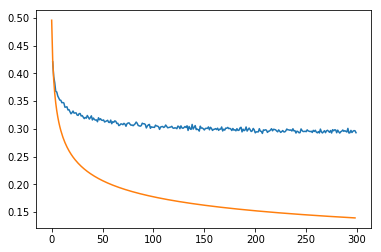

In [94]:
plt.plot(range(1,300), avgs)
plt.plot(target_func(np.arange(1, 300), 0.22295833, 0.49594636))

In [ ]:
def func_powerlaw(x, m, c, c0):
    return x**m * c + 0
def func_exp(x, A, B):
    return A * np.exp(B * np.asarray(x))
target_func = func_powerlaw
k, v = list(zip(*m.items()))
plt.figure(figsize=(15,10))
plt.plot(k, v)
# plt.plot(np.array(k), target_func(np.array(k), -0.25, 0.08, 0))

print(f"popt: {popt}")
plt.plot(k, target_func(np.array(k), *popt))

target_func = func_exp
popt, pcov = curve_fit(target_func, k, v, p0 = np.asarray([0.2, -0.08]), maxfev=2000)
print(f"popt {popt}")
plt.plot(k, target_func(np.array(k), *popt))


In [54]:
v

In [55]:
v[0].get_cur_mean([100])

99.99999999

In [56]:
v[1].get_cur_mean([])

0.0

In [9]:
state = np.load("ising_samples/ising6561x6561_temp_2.269185_sample1571863655.881323.npy") # np.random.choice([-1, 1], (size, size))
plt.imshow(state)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'ising_samples/ising6561x6561_temp_2.269185_sample1571863655.881323.npy'

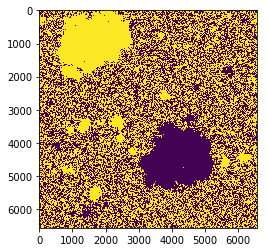

In [184]:
state = np.load("ising_samples/ising6561x6561_temp_2.269185_sample1571858818.602564.npy") # np.random.choice([-1, 1], (size, size))
plt.imshow(state)
plt.show()

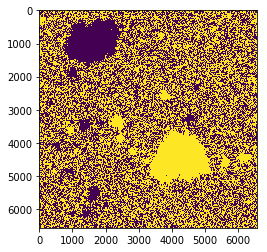

In [158]:
state = np.load("ising_samples/ising6561x6561_temp_2.269185_sample1571854227.0954611.npy") # np.random.choice([-1, 1], (size, size))
plt.imshow(state)
plt.show()

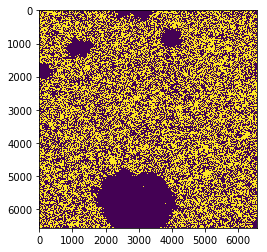

In [168]:
state = np.load("ising_samples/ising6561x6561_temp_2.269185_sample1571858426.648014.npy") # np.random.choice([-1, 1], (size, size))
plt.imshow(state)
plt.show()

In [176]:
!ls ising_2187/

ls: ising_2187/ising_2187: Not a directory


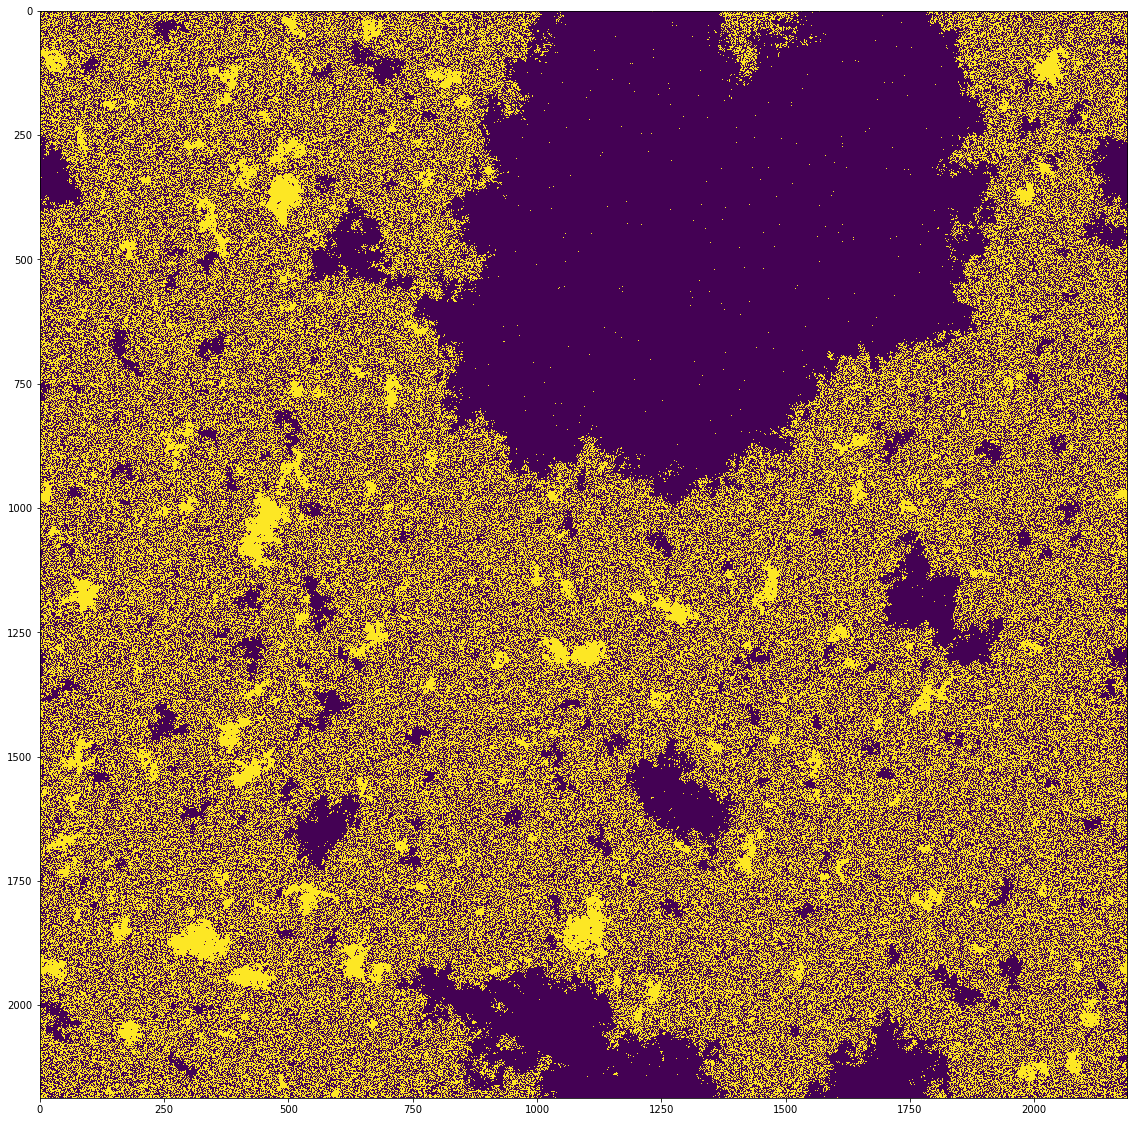

In [200]:
state = np.load("ising_2187/ising2187x2187_temp_2.359185_sample1571871268.283772.npy") # np.random.choice([-1, 1], (size, size))
plt.figure(figsize=(25,20))
plt.imshow(state)
plt.show()
T = 2.35 

In [198]:
m = correlation_check(state = state[None, None, :, :])


In [155]:
func_powerlaw(2, -0.16825665,  0.45027981, -0.001)

0.40071184059018233

In [166]:
def sigmoid(x, L = 1, k = 0.002, x0 = 500):
    return L / (1 + np.exp(-k*(np.array(x)-x0)))

popt: [-0.03153214  0.80034964 -0.001     ]
popt [ 7.30860879e-01 -3.85882290e-04]


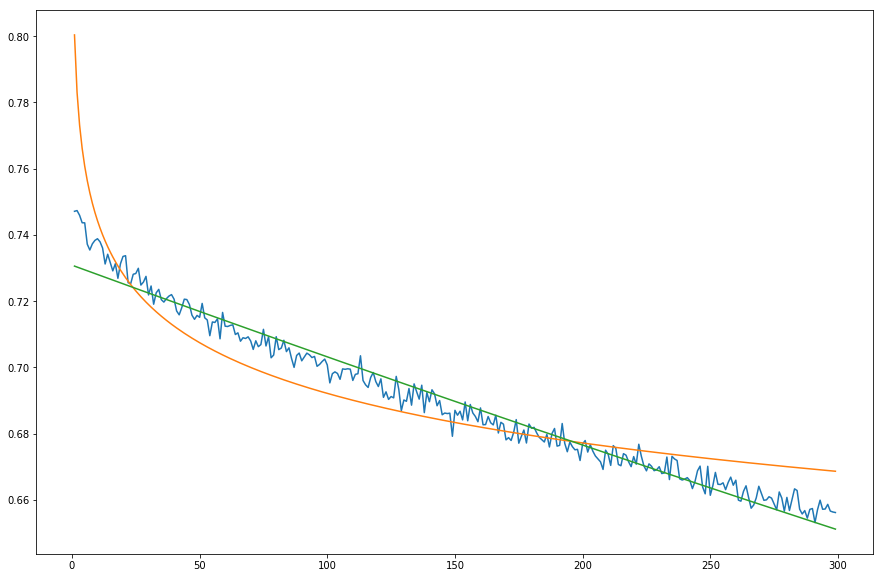

In [199]:
def func_powerlaw(x, m, c, c0):
    return x**m * c + 0
def func_exp(x, A, B):
    return A * np.exp(B * np.asarray(x))
target_func = func_powerlaw
k, v = list(zip(*m.items()))
plt.figure(figsize=(15,10))
plt.plot(k, v)
# plt.plot(np.array(k), target_func(np.array(k), -0.25, 0.08, 0))
popt, pcov = curve_fit(target_func, k, v, p0 = np.asarray([-0.2, 0.24, -0.001]), maxfev=20000)
print(f"popt: {popt}")
plt.plot(k, target_func(np.array(k), *popt))

target_func = func_exp
popt, pcov = curve_fit(target_func, k, v, p0 = np.asarray([0.2, -0.08]), maxfev=2000)
print(f"popt {popt}")
plt.plot(k, target_func(np.array(k), *popt))


# Analyze new data set from Kiel

In [20]:
import numpy as np
from glob import glob 

file_list = glob("ising81x81/*")
groups = [0] # range(0, 10000, 10)
for group in groups:
    lat_list = []
    for lat in file_list[group:(group+10000)]:
        lat = np.load(lat)
        lat_list.append(lat["arr_0"])
    lat_list = np.array(lat_list)
    print(lat_list.shape)
    break

(10000, 81, 81)


In [22]:
np.savez_compressed("ising81x81.npz", lat_list, array1 = lat_list)

In [1]:
import numpy as np
v = np.load("ising_dat/data_2187_1572395896/lattice_08750_chain_3.npz")

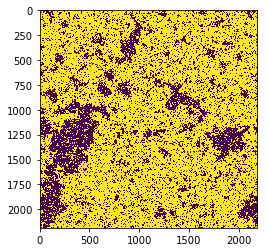

In [6]:
import matplotlib.pyplot as plt
plt.imshow(v["arr_0"])
plt.show()

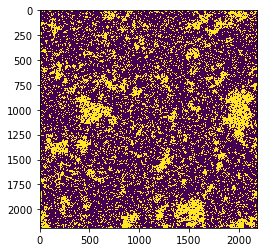

In [7]:
v = np.load("ising_dat/data_2187_1572395896/lattice_08751_chain_3.npz")
plt.imshow(v["arr_0"])
plt.show()

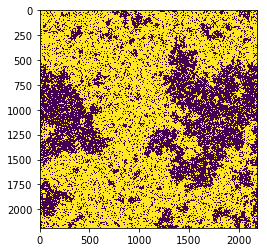

In [9]:
v = np.load("ising_dat/data_2187_1572395896/lattice_08753_chain_3.npz")
plt.imshow(v["arr_0"])
plt.show()

In [1]:
len([689201, 117183, 114788, 630695, 127895, 128674, 52829, 9532, 6026, 36862, 6285, 21891, 8520, 10718, 4306, 4717, 5555, 51292, 8334, 21841, 30613, 8688, 9516, 5157, 45978, 20904, 7126, 47087, 8956, 3836, 4549, 14763, 4215, 3400, 14461, 5051, 3124, 20551, 4735, 3526, 7407, 18736, 9568, 18794, 2810, 2640, 3341, 4909, 3342, 2893, 2227, 1863, 2625, 4044, 2369, 2011, 1681, 4218, 2230, 4324, 4820, 3396, 892, 1787, 1536, 2436, 3556, 2605, 3058, 3091, 2516, 2700, 2603, 2470, 1555, 2223, 2822, 1842, 1489, 1421, 770])

81